In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, KBinsDiscretizer, OneHotEncoder, Binarizer, \
    FunctionTransformer, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
heart_disease = pd.read_csv('heart_disease.csv')

# Data types

From https://archive.ics.uci.edu/dataset/45/heart+disease

| Variable Name | Code   | Role     | Type          | Demographic                | Description                                     | Units   | Missing Values |
|-----|--------|----------|---------------|----------------------------|-------------------------------------------------|---------|----------------|
| `age` | #3     | Feature  | Integer       | Age                        | Age in years                                   | years   | no             |
| `sex` | #4     | Feature  | Categorical   | Sex                        | Sex (1 = male; 0 = female)                     |         | no             |
| `cp` | #9     | Feature  | Categorical   |                            | Chest pain type: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic |         | no             |
| `trestbps` | #10    | Feature  | Integer       |                            | Resting blood pressure (in mm Hg on admission to the hospital) | mm Hg   | no             |
| `chol` | #12    | Feature  | Integer       |                            | Serum cholesterol in mg/dl                     | mg/dl   | no             |
| `fbs` | #16    | Feature  | Categorical   |                            | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false) |         | no             |
| `restecg` | #19    | Feature  | Categorical   |                            | Resting electrocardiographic results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy |         | no             |
| `thalach` | #32    | Feature  | Integer       |                            | Maximum heart rate achieved                    |         | no             |
| `exang`| #38    | Feature  | Categorical   |                            | Exercise-induced angina (1 = yes; 0 = no)      |         | no             |
| `oldpeak` | #40    | Feature  | Integer       |                            | ST depression induced by exercise relative to rest |         | no             |
| `slope`| #41    | Feature  | Categorical   |                            | Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping |         | no             |
| `ca`| #44    | Feature  | Integer       |                            | Number of major vessels (0–3) colored by fluoroscopy |         | yes            |
| `thal`| #51    | Feature  | Categorical   |                            | Thal: 3 = normal, 6 = fixed defect, 7 = reversible defect |         | yes            |
| `num`| #58    | Target   | Integer       |                            | Diagnosis of heart disease (angiographic disease status): 0 = <50% diameter narrowing, 1 = >50% |         | no             |

## Feature categorisation
Lets assign the column names to numeric or categorical features based on data description

In [4]:
numeric_features = [
    'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'
]
categorical_features = [
    'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'
]


## Missing data
The `ca` and `thal` features are flagged as missing values

In [5]:
heart_disease['ca'].value_counts()

ca
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64

In [6]:
heart_disease['thal'].value_counts()

thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64

Only a few missing values, easier to just drop the rows and convert the rest to ints

## Data cleaning pipeline
We want to create a pipeline for how the data will be transformed, and fit and encoded

### Drop rows with '?'
Let's just drop the data from the frame

In [7]:
# Drop missing values
heart_disease = heart_disease[~heart_disease.isin(['?']).any(axis=1)]

## Converting columns to numeric
The `ca` and `thal` columns are strings. They need to be made numeric

In [8]:
# Convert the `ca` and `thal` columns to numeric
heart_disease['ca'] = pd.to_numeric(heart_disease['ca'])
heart_disease['thal'] = pd.to_numeric(heart_disease['thal'])

### Scaling
For the numeric features, we need to work out what transforms will be appropriate based upon their distributions

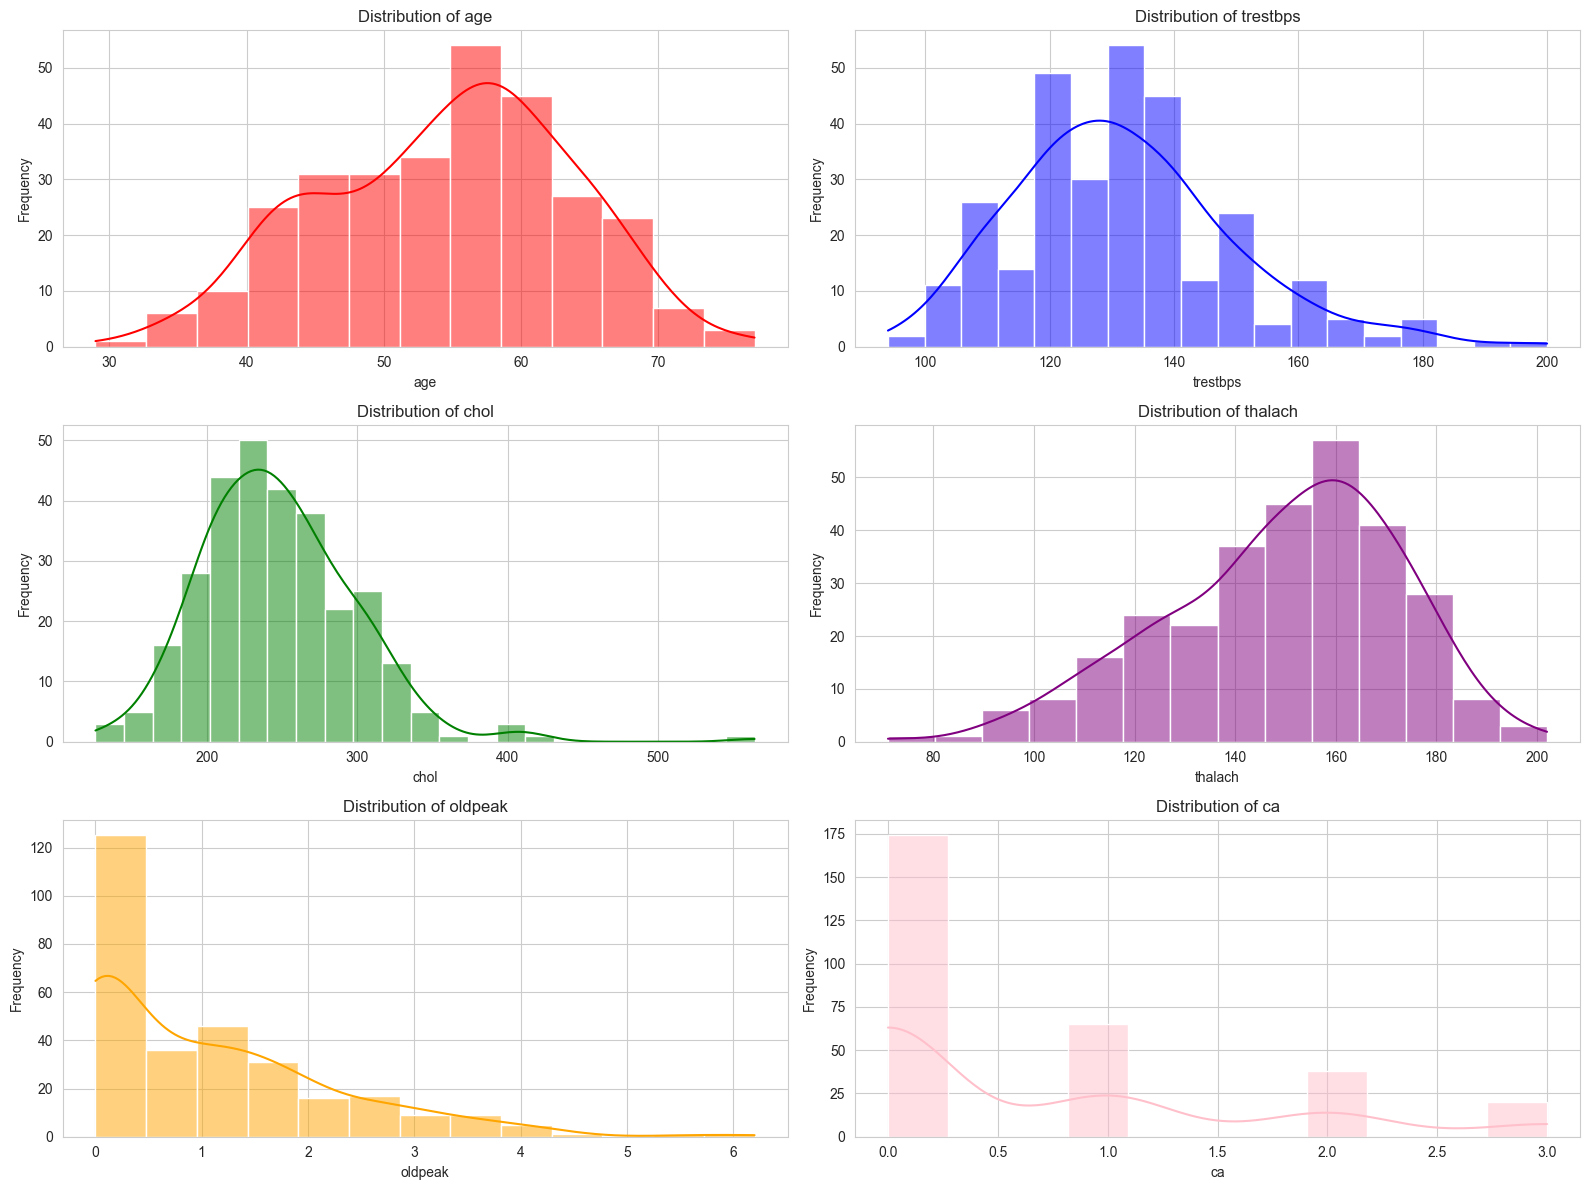

In [9]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']  # Define a list of colors for the plots

fig, axes = plt.subplots(nrows=(len(numeric_features) + 1) // 2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(numeric_features):
    sns.histplot(heart_disease[column], kde=True, bins="auto", color=colors[i % len(colors)], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Comments
Generally it appears as all these distributions contain one primary distribution, and a secondary smaller peak. `oldpeak` and `ca` are heavily skewed to the 0 result, because there are no negative results that make sense
### Scaling required
- `age`, `trestbps`, `thalach` are approximately normally distributed so StandardScaler will work fine
- `chol` appears to be right skewed, and has some outliers, we'll need to use RobustScaler
- `oldpeak` is heavily right skewed, so we'll need to use a MinMax or QuantileTransformer
- `ca` is also heavily right skewed, so we'll need to use a MinMax or QuantileTransformer


In [10]:
scaling_encoding = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['age', 'trestbps', 'thalach']),
    ('chol', RobustScaler(), ['chol']),
    ('oldpeak', MinMaxScaler(), ['oldpeak']),
    ('ca_num', MinMaxScaler(), ['ca']),  # For numeric features of 'ca'
    ('cp', OneHotEncoder(), ['cp']),
    ('restecg', OneHotEncoder(), ['restecg']),
    ('slope', OneHotEncoder(), ['slope']),
    ('ca_cat', OneHotEncoder(), ['ca']),  # For categorical features of 'ca'
    ('thal', OneHotEncoder(), ['thal']),
    ('exang', "passthrough", ['exang']),
    ('fbs', "passthrough", ['fbs']),
    ('sex', "passthrough", ['sex']),
])

In [11]:
pipeline = Pipeline(steps=[
    ('preprocessor', scaling_encoding),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='saga', penalty='elasticnet', l1_ratio=0.5))
])

In [12]:
# Split data into X (features) and y (target)
X = heart_disease.drop(columns=['present']).iloc[:, 1:]  # Drop the first column (index)
y = heart_disease['present']

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42, stratify=y_train_val)



In [13]:
# Display the number of samples in each set in a table
data_counts = {
    "Set": ["Full Dataset", "Training Set", "Validation Set", "Test Set"],
    "Samples": [len(y), len(y_train), len(y_val), len(y_test)],
    "Presence (1)": [y.sum(), y_train.sum(), y_val.sum(), y_test.sum()],
    "Absence (0)": [len(y) - y.sum(), len(y_train) - y_train.sum(), len(y_val) - y_val.sum(), len(y_test) - y_test.sum()],
    "Ratio (Presence/Absence)": [
        y.sum() / (len(y) - y.sum()),
        y_train.sum() / (len(y_train) - y_train.sum()),
        y_val.sum() / (len(y_val) - y_val.sum()),
        y_test.sum() / (len(y_test) - y_test.sum())
    ]
}
table = pd.DataFrame(data_counts)
print("\nNumber of samples in each set (with presence and absence counts):")
print(table)


Number of samples in each set (with presence and absence counts):
              Set  Samples  Presence (1)  Absence (0)  \
0    Full Dataset      297           137          160   
1    Training Set      118            54           64   
2  Validation Set      119            55           64   
3        Test Set       60            28           32   

   Ratio (Presence/Absence)  
0                  0.856250  
1                  0.843750  
2                  0.859375  
3                  0.875000  


# Dataset split
At a glance, the distribution of heart disease in the different sets seems to be consistent

In [14]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on validation data
y_val_pred = pipeline.predict(X_val)

In [15]:
from sklearn.metrics import confusion_matrix, f1_score

# Get confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Extract components of confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)    # Positive Predictive Value
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = f1_score(y_val, y_val_pred)  # F1 Score

# Print metrics
print("Validation Set Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Validation Set Metrics:
Sensitivity (Recall): 0.82
Specificity: 0.83
Precision: 0.80
Accuracy: 0.82
F1 Score: 0.81


In [16]:
# Evaluate the pipeline on the test data
y_test_pred = pipeline.predict(X_test)

# Get confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Extract components of confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)    # Positive Predictive Value
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = f1_score(y_test, y_test_pred)  # F1 Score

# Print metrics
print("\nTest Set Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")


Test Set Metrics:
Sensitivity (Recall): 0.82
Specificity: 0.84
Precision: 0.82
Accuracy: 0.83
F1 Score: 0.82


# Model results
The test and validation set give similar results, so our fit is ok. We'll improve it later, but let's check the coeffcients



In [21]:
# Retrieve column names and coefficients from the pipeline
feature_names = scaling_encoding.get_feature_names_out()
coefficients = pipeline.named_steps['classifier'].coef_[0]
log_odds = [np.exp(coef) for coef in coefficients]

# Combine feature names and coefficients into a DataFrame for better readability
coef_df = pd.DataFrame({'Feature': feature_names, 'Log-Odds': coefficients, 'Odds': log_odds})

# Display the dataframe in descending order by 'Log-Odds'
coef_df = coef_df.sort_values(by='Log-Odds', ascending=False)
coef_df

,Feature,Log-Odds,Odds
9,cp__cp_4,1.500510,4.483977
22,thal__thal_7.0,1.079907,2.944406
25,sex__sex,1.024152,2.784732
3,chol__chol,0.589775,1.803582
5,ca_num__ca,0.513082,1.670431
18,ca_cat__ca_2.0,0.349063,1.417739
4,oldpeak__oldpeak,0.211721,1.235803
12,restecg__restecg_2,0.189149,1.208222
1,num__trestbps,0.142231,1.152843
14,slope__slope_2,0.086325,1.090160


In [ ]:
heart_disease['cp'].value_counts()

In [25]:
heart_disease['thal'].value_counts()


thal
3.0    164
7.0    115
6.0     18
Name: count, dtype: int64

# Coefficients
From the model, it's clear that some predictors contribute nothing to the classification, namely
- `cp__cp_2`
- `ca_cat__ca_3.0`
- `thal__thal_6.0`
- `fbs__fbs`
- `restecg__restecg_1`
- `slope__slope_3`

Some predictors have a large predictive power
- `cp__cp_4` asymptomatic chest pain indicates that at the time of examination, the heart disease had not progressed to the point of causing pain. A little under half the dataset presented no chest pain
- `thal__thal_7.0` around a bit over a third of dataset had a reversible defect from Thalassemia
- `sex__sex` as might be expected, the gender of the patient has strong predictive power
- `chol` cholesterol also strong at predicting heart disease, sits with common knowledge people have about the circulatory system and the heart
- `ca_num__ca` the number of blood vessels, incorrect or restricted blood flow will lead to heart disease, so the number of vessels being lower than expected would be a strong predictor.

# Improving the model
We can make our model a bit simpler by removing the features we don't need. We'll use Recursive Feature Elimination (RFE) with Cross Validation to work out the optimum number of features.



In [67]:
from sklearn.feature_selection import RFECV
# Define Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42, solver='saga', penalty='elasticnet', l1_ratio=0.5)

# Implement RFECV with Logistic Regression
rfecv = RFECV(
	estimator=logistic_model,
	cv=5,  # 5-fold cross-validation
	scoring='f1',  # You can choose other metrics like 'f1', 'roc_auc', etc.
	step=1,
    min_features_to_select=5
)

# Create the full pipeline
rfecv_pipeline = Pipeline(steps=[
	('preprocessor', scaling_encoding),  # Preprocessing step
	('feature_selector', rfecv)  # Perform RFECV with logistic regression
])

# Fit the rfecv_pipeline to the training data
rfecv_pipeline.fit(X_train, y_train)

# Evaluate the rfecv_pipeline on validation data
y_val_pred = rfecv_pipeline.predict(X_val)

# Get mask of selected features
selected_features = rfecv_pipeline.named_steps['feature_selector'].support_

# Get feature rankings
feature_rankings = rfecv_pipeline.named_steps['feature_selector'].ranking_

# Get optimal number of features
optimal_features = rfecv_pipeline.named_steps['feature_selector'].n_features_

print("Selected Features:", selected_features)
print("Feature Rankings:", feature_rankings)
print(f"Optimal Number of Features: {optimal_features}")


Selected Features: [False False  True  True  True  True False False  True  True False False
  True  True False False  True False  True False  True False  True False
 False  True]
Feature Rankings: [ 5  2  1  1  1  1  3 14  1  1  7 12  1  1  4 13  1  8  1  9  1 11  1  6
 10  1]
Optimal Number of Features: 13


In [59]:
# Fit the rfecv_pipeline to the training data
rfecv_pipeline.fit(X_train, y_train)

# Evaluate the rfecv_pipeline on validation data
y_val_pred = rfecv_pipeline.predict(X_val)

# Get mask of selected features
selected_features = rfecv_pipeline.named_steps['feature_selector'].support_

# Get feature rankings
feature_rankings = rfecv_pipeline.named_steps['feature_selector'].ranking_

# Get optimal number of features
optimal_features = rfecv_pipeline.named_steps['feature_selector'].n_features_

print("Selected Features Mask:", selected_features)
print("Feature Rankings:", feature_rankings)
print(f"Optimal Number of Features: {optimal_features}")

# Display which features were selected with their names
feature_names = scaling_encoding.get_feature_names_out()
selected_feature_names = [name for i, name in enumerate(feature_names) if selected_features[i]]
print("Selected Feature Names:", selected_feature_names)

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 featur

In [60]:
# Get confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Extract components of confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)    # Positive Predictive Value
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = f1_score(y_val, y_val_pred)  # F1 Score

# Print metrics
print("Validation Set Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Validation Set Metrics:
Sensitivity (Recall): 0.82
Specificity: 0.81
Precision: 0.79
Accuracy: 0.82
F1 Score: 0.80


In [66]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
	# Logistic Regression hyperparameters
	'feature_selector__estimator__C': [0.01, 0.1, 1.0, 10.0],  # Regularization strength
	'feature_selector__estimator__solver': ['saga'],  # Solver for optimization
	'feature_selector__estimator__penalty': ['l2', 'elasticnet', None],  # Regularization type (allowing ElasticNet)
	'feature_selector__estimator__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'feature_selector__estimator__fit_intercept': [True, False],
	# ElasticNet mixing ratio (only for saga solver)
	'feature_selector__estimator__max_iter': [500],  # Maximum number of iterations for optimization

	# RFECV specific parameters
	'feature_selector__cv': [5],  # Number of CV folds
	'feature_selector__step': [1],  # Number of features to eliminate in each step
	'feature_selector__min_features_to_select': [1, 3, 5],  # Minimum number of features to retain
}

# Instantiate RandomizedSearchCV
grid_search = GridSearchCV(
    estimator=rfecv_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=3,
    n_jobs=2
)

# Execute random search
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning:

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.


C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\User\Dataquest.IO\Guided Project - Popular Data Science Questions\GuidedProjectDataScienceQuestions\venv\Lib\site-packages\sklearn\linear_model\_log